# Testing out numerical solver code

## current setup
crank-nicholson gmres solver and pme cell diffusion 

## Objectives 
* i think to do this you'll need to do a sweep over induction start and end times for each sender type. do this by starting and stopping simulations, toggling xSa/b to 0 and back, then continuing. 
* scale the size of the colony too? put in a no-amplify control as well?

## Model considerations 



$$ \partial_t c = F(c)$$
$$ \partial_t c = (D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)$$
Crank-Nicolson approach is to take 
$$ \frac{c_{n+1}-c_n}{\Delta t} = \frac{F(c_n)+F(c_{n+1})}{2} $$
When jacobian is available
$$ c_{n+1} = c_n + \Delta t \frac{F(c_n)+F(c_n) + J(c)(c_{n+1}-c_n))}{2} $$
$$ (1 - \Delta t J(c)/2) c_{n+1}  = (1 - \Delta t J(c_n)/2)c_n  + \Delta t F(c)$$
$$ (D_a+2D_c)\nabla^2c_n + 2D_c|\nabla c_n|^2+f(c_n) + (D_a+2D_c)\nabla^2c_{n+1} + 2D_c|\nabla c_{n+1}|^2+f(c_{n+1})$$
$$ c_{n-1} = c_n \Delta t ((D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)) $$



In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Try to find out why solvers quit with too_small_step error

In [29]:
import importlib
from omnisim import pme_coincidence_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,    rc,    rS, rR,    Hn,Kn,   Dn,     kn,        Daa,  Dab,   xa,    xs,  xSa, xSb
p0 = np.array([1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, 1.6e-2, 7e-4, 7e-4, 1e-2, 250, 300, 300,
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.01], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Daa,Dab,xa,xs,xSa,xSb,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1

simmer = oms.Simulator(scale=16)
# simmer.set_scale(4)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

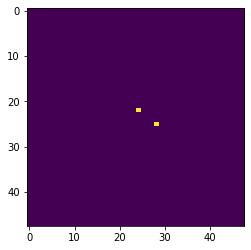

In [30]:
species = 13
cr_i, csa_i, csb_i, cpa_i, cpb_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i, o_i = np.arange(species)
plt.imshow(simmer.initial_array[csa_i,:,:])

In [31]:
simmer.set_p0(p0)
# simmer.initial_array = skimage.filters.gaussian(simmer.initial_array, sigma=(0,1/4,1/4))

from omnisim.solvers import impexp_cnmg_rk_coincidence 
impexp_cnmg_rk = importlib.reload(impexp_cnmg_rk_coincidence)
# cnmg = cnmg_rk.cn_mg(simmer, 1e-2)
# impexp = impexp_cnmg_rk.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

In [32]:
for method in ['RK45', 'BDF', 'Radau', 'LSODA']:
    rtime = time.time()
    try:
        simmer.sim(p0,method=method)
    except:
        print(method + " failed")
        continue
    rtime = time.time() - rtime
    print(method)
    print(rtime)
    print(simmer.out)

RK45
20.04806423187256
  message: 'Required step size is less than spacing between numbers.'
     nfev: 8744
     njev: 0
      nlu: 0
      sol: None
   status: -1
  success: False
        t: array([0.])
 t_events: None
        y: array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])
 y_events: None
BDF failed
Radau
2.4190144538879395
  message: 'Required step size is less than spacing between numbers.'
     nfev: 353
     njev: 4
      nlu: 116
      sol: None
   status: -1
  success: False
        t: array([0.])
 t_events: None
        y: array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])
 y_events: None
LSODA failed


In [23]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nh, nw, _ = simmer.dims
ys = []
ts = []
for dt in [5e-1,1e-1,5e-2]:
#     simmer.initial_array = initial_array.copy()
    impexp = impexp_cnmg_rk.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 100
    rtime = time.time()
    try:
        for i in np.arange(n_loops):
            impexp._step_impl()
            if i%20:
                continue
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
    except Exception as e:
        print(e)
        print('failed {}'.format(dt))
    rtime = time.time() - rtime
    print(rtime/60)
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

gmres failed 1198080

failed 0.5
0.03654906749725342
gmres failed 1198080

failed 0.1
0.1654874324798584
gmres failed 1198080

failed 0.05
0.6043613036473592


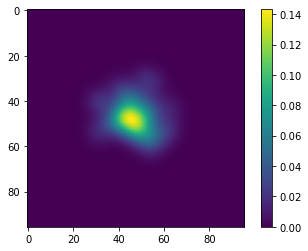

In [25]:
y_arr = ys[-1].copy()
y_arr = simmer.initial_array.copy()
y_arr.shape = (ns,nh,nw)
plt.imshow(y_arr[cpb_i,...])
plt.colorbar()

In [48]:
oms = importlib.reload(oms)
simmer = oms.Simulator(8)
scale = simmer.scale
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

# Params :    ,Dc,    rc,    rS, rR,    Hn,Kn,   Dn,     kn,      Da,   xa,    xs,  xS,
p0 = np.array([0,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, 1.6e-2, 7e-4, 1e-2, 250, 100, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.1], dtype=np.float64)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
initial_array[cs_slice][0,scale:-scale,scale:2*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,scale:-scale,3*scale:-scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [70]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [71]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [74]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

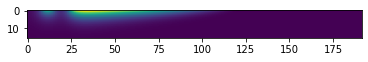

In [84]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

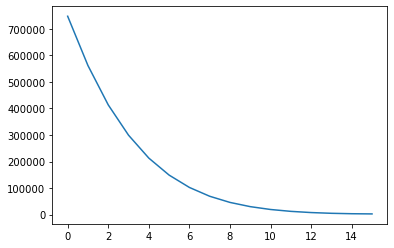

In [85]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),50])

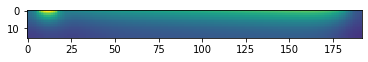

In [62]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

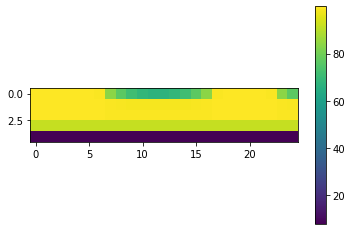

In [38]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

In [61]:
print([np.prod(xx) for xx in impexp.cnmg_solver.level_shape])
print([ xx.get_dif_jac().shape for xx in impexp.cnmg_solver.level_jacobian])

[258048, 39936, 6912]
[(258048, 258048), (39936, 39936), (6912, 6912)]


In [ ]:
x = im_arr[5,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
n = len(x0)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb_wrxn(x)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# b.shape = (len(b),1)
# x.shape = (len(x),1)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
class Callback():
    def __init__(self, A, b):
        self.i=0
        self.A = A
        self.b = b
    
    def plot_err(self, x0):
        plt.plot(self.i, np.log10(linalg.norm(self.A.dot(x0)-self.b.flatten())),'.k')
        self.i += 1
    
cb = Callback(A, b)
    
M = splinalg.LinearOperator(shape=(n,n), matvec=splinalg.spilu(A.tocsc()).solve)
out = splinalg.gmres(A, b, x,callback=cb.plot_err, callback_type='x')
if out[1] != 0:
    print('error')
x = out[0]

In [ ]:
A = cnmg.cn_lhsA(h)
b = cnmg.cn_rhsb_wrxn(x)
x = im_arr[1,:,:,:].flatten()
%time cnmg.w_cycle(x.copy(),b,0)
%time splinalg.gmres(A, b, x)#, maxiter=10)

In [ ]:
impexp.rk_solver.h_abs

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=2
x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(40):
    print(i)
    cnmg_rk.gauss_seidel(A, b, x, n_iter=1, w=0.5)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
Da

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# for i in np.arange(4):
#     print(i)
#     cnmg.v_cycle(x, b, h, n_iter=5)
#     plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')
%timeit splinalg.minres(A,b,x)

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x0 = x.copy()
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(4):
    print(i)
    cnmg.f_cycle(x, b, h, n_iter=5)
#     x,_ = splinalg.gmres(A,b,x)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
for i in np.arange(4):
    print(i)
    cnmg.w_cycle(x, b, h, n_iter=5)
    plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# %lprun -f cnmg_rk.gauss_seidel cnmg_rk.gauss_seidel(A, b, x, n_iter=5)
# plt.plot(i, np.log10(linalg.norm(A.dot(x)-b)),'.k')

In [ ]:
def test1():
    i = 10
    Arow = A.getrow(i)
    _, inds = Arow.nonzero()
    # print(inds)
    sigma = 0
    for j in inds:
        if j != i:
            sigma += Arow[j]*x[j]
            
def test2():
    i = 10
    Arow = A.getrow(i).toarray()[0,:]
    Arow[i] = 0
    inds = Arow != 0
    # print(inds)
    sigma = 0
    for Aij, xj in zip(Arow[inds], x[inds]):
            sigma += Aij*xj

%timeit test1()
%timeit test2()

In [ ]:
def test1(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    while n_iter > 0 and residual > conv_eps:
        for i in np.arange(n):
            sigma = 0
            Arow = A.getrow(i)
            _, j_inds = Arow.nonzero()
            for j in j_inds:
                if j != i:
                    sigma = sigma + x[j]*Arow[0,j]
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] -x[i])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)

def test2(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    while n_iter > 0 and residual > conv_eps:
        sigma = 0
        for i in np.arange(n):
            sigma = 
            x[i_old] = x[i_old] + w*((b[i_old]-sigma)/diag[i_old] -x[i_old])
            sigma = 0
            i_old = i

        n_iter -= 1
        residual = matnorm(A.dot(x)-b)
        

# %timeit test1(x.copy())
# %timeit test2(x.copy())

In [ ]:
splinalg.norm(x1-x2)

In [ ]:
x = im_arr[50,:,:,:].flatten()
h=0
# x = cnmg.downscale(x, 0,h)
A = cnmg.cn_lhsA(h)#np.array([[4,-1,-6,0],[-5,-4,10,8],[0,9,4,-2],[1,0,-7,5]]).astype(np.float)
b = cnmg.cn_rhsb(x,h)#np.array([[2,21,-12,-6]]).T.astype(np.float)
# x_true = linalg.solve(A,b)
# x = np.zeros_like(b)
# for i in np.arange(40):
#     print(i)
#     test2(x)
#     plt.plot(i, linalg.norm(A.dot(x)-b),'.k')

In [ ]:
def test1(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    i_nd_un = np.unique(i_nd)
    while n_iter > 0 and residual > conv_eps:
        for i in np.arange(n):
            if i in i_nd_un:
                mask = i_nd==i
                sub_j = j_nd[mask]
                sigma = np.sum([A[i,j]*x[j] for j in sub_j])
            else:
                sigma = 0
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] -x[i])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)

def test2(x):
    w = 0.5
    n_iter = 5
    conv_eps = 1e-4
    n = len(x)
    #matnorm = norm
    matnorm = np.max
    diag = A.diagonal()
    # Perform relaxation
    residual = matnorm(A.dot(x)-b)
    ainz, ajnz = A.nonzero()
    nondiag = (ainz - ajnz) != 0
    i_nd, j_nd = ainz[nondiag], ajnz[nondiag]
    i_nd_un = np.unique(i_nd)
    while n_iter > 0 and residual > conv_eps:
        i_old = 0
        for i in i_nd_un:
            if i-i_old>1:
                x[i_old:i] = x[i_old:i] + w*(b[i_old:i]/diag[i_old:i] - x[i_old:i])
            mask = i_nd==i
            sub_j = j_nd[mask]
            sigma = np.sum([A[i,j]*x[j] for j in sub_j])
            x[i] = x[i] + w*((b[i]-sigma)/diag[i] - x[i])
            i_old = i
        i += 1
        if n-i>=1:
            x[i:] = x[i:] + w*(b[i:]/diag[i:] - x[i:])
        n_iter -= 1
        residual = matnorm(A.dot(x)-b)
        

%time test1(x.copy())
%time test2(x.copy())

In [ ]:
x1, x2 = x.copy(), x.copy()
test1(x1)
test2(x2)
linalg.norm(x1-x2)

In [ ]:
np.arange(len(x))[x1-x2==np.max(x1-x2)]//(nh*nw)

In [112]:
from scipy.sparse import linalg as splinalg

In [ ]:
ran_inds = lambda n_inds : np.random.choice(np.arange(len(x)), n_inds)
n = 100
%timeit A[ran_inds(n),ran_inds(n)]
%timeit [row.getcol(ran_inds(1)[0]) for row in [A.getrow(ran_inds(1)[0]) for yy in range(n)] for xx in range(n)]
%timeit [A[i,j] for i in ran_inds(n) for j in ran_inds(n)]

In [ ]:
N = 10000
M = 500
vol_weights = np.random.random(M)+0.5
vol_weights[0] = 1e3
sum_vol = vol_weights.sum()
avg_conc = n/sum_vol
